In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Introducing SU(N)

The matrix (lie) group $\text{S}_\text{pecial}\text{U}_\text{nitary}$(N) consists of $N \times N$ matrices that are Special ($\text{det}(g) = 1$) and Unitary $gg^\dagger = g^\dagger g = 1$. One of the easy constructions of the Lie Algebra comes from it's identification with the tangent space at the identity. In other words, a matrix $X$ is in the lie algebra if:
$$1 + \epsilon X \in SU(N) \text{ up to } O(\epsilon^2)$$
Checking the two conditions, we find that:
$$\text{det}(\delta_{ij} + \epsilon X_{ij}) = 1 + \epsilon X_ii + O(\epsilon^2), \quad \implies \quad X_{ii} = \text{Tr}(X) = 0$$
$$(\delta_{ij} + \epsilon X_{ij})^\dagger (\delta_{jk} + \epsilon X_{jk}) = \delta_{ik} +  \epsilon (X_{ik}^\dagger + X_{ik}) + O(\epsilon^2), \quad \implies \quad X^\dagger = -X $$
In other words, the lie algebra $\mathfrak{su}(N)$ consists of $N \times N$ tracelss, skew-hermitian matrices. 

# 2. Random Walks on SU(N)

All compact lie groups come equipped with natural unique bi-invariant Haar measures $dg$, defined by the equations:
$$\int f(g_1 g) dg = \int f(g g_1) dg = \int f(g)$$
There are various ways to sample from ths measure, perhaps one of the simplest is to define a markov-chain on the group, where on each iteration we multiply by some small element near the identity; effectively 'random-walking' across the group. It seems intuitively clear that this procedure will recover the haar measure, a paper that talks about the details is [here](https://arxiv.org/pdf/1209.1745.pdf) (in particular, Corollary 7 describes even the rate of convergence in some sense). We won't worry too much about the technicalities, but rather just jump in. First, let's write some functions to get the basis of the su(N) lie algebras.

In [2]:
def delta_matrix(i,j,N):
    """
    Convenience, returns delta_ij matrix (lives in NxN matrices)
    """
    return np.array([[(k == i)*(l == j) for l in range(N)] for k in range(N)])

def su_basis(N):
    """
    Returns a basis for su(N) lie algebra
    """
    basis = []
    for i in range(N-1):
        #diagonal basis elements
        basis.append(1j*delta_matrix(i,i,N) - 1j*delta_matrix(N-1,N-1,N))
        for j in range(i+1,N):
            #off-diagonal basis elements
            basis.append(delta_matrix(i,j,N) - delta_matrix(j,i,N))
            basis.append(1j*delta_matrix(i,j,N) + 1j*delta_matrix(j,i,N))
    return basis

In [93]:
for sigma in su_basis(2):
    print(sigma)

[[0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j]]
[[ 0  1]
 [-1  0]]
[[0.+0.j 0.+1.j]
 [0.+1.j 0.+0.j]]


We can check that for the su(2) basis, we have $i$\*the pauli matrices, which is exactly what we expect (since physicists use the convention of writing the basis of su(N) in terms of hermitian matrices, which is different by a factor of $i$ to its 'usual definition'. Now, we can define a measure on the lie group, and define our random walk. We also need a function that will project the matrices to $SU(N)$, since we will have errors where the random walk drifts off, how are we to do this? Note that the unitarity conditon $U^\dagger U = 1$ ensures that each of the rows of the unitary matrix are orthonormal. So, to project we can follow the gram-schmidt normalization procedure, which you might be familiar with from perturbation theory:
$$u_1 = v_1, \quad u_2 = v_2 - \text{proj}_{u_1} (v_2), \quad u_3 = v_3 - \text{proj}_{u_1} (v_3) - \text{proj}_{u_2} (v_3), \quad \dots$$
where the $v_i$ are the rows of the matrix initially, and the (normalized) u_i are the rows of the projected matrix. We also need to check the special det=1 condition, which means an additional phase factor for one of the rows to cancel out the determinant. 

In [3]:
def random_SU(N,basis,eps):
    return np.identity(N) + eps*np.tensordot(basis,np.random.random(size=(len(basis))),axes=(0,0))

def proj(v,u):
    """
    project v onto u
    """
    #might have the conj the wrong way around
    return (np.dot(u.conj(),v)/np.dot(u.conj(),u))*u

def project_SU(N,X):
    Y = []
    for i in range(N):
        u = X[i]
        for j in range(i):
            u = u - proj(X[i],Y[j])
        Y.append(u/np.linalg.norm(u))
    d = np.linalg.det(Y)
    Y[-1] = Y[-1]/(d/np.linalg.norm(d))
    return np.array(Y)

Now, we are ready to do a random walk on the SU(N) groups! But how will we see the random walk? There are various projections from $SU(N) \to \mathbb{R}$ that might make it easier to see whats going on, for example we can look at the Trace, then we can make plots like this:

In [11]:
def make_plot_trace(N,eps,num_iter,num_record,num_print,ax):
    #plt.figure(figsize=(8,8))
    b = su_basis(N)
    X = np.identity(N)
    for it in range(num_iter):
        if it%num_print == 0:
            print("On iteration",it)
        X = np.matmul(X,random_SU(N,b,eps))
        X = project_SU(N,X)
        if np.trace(X).real > 100:
            break
        if it%num_record == 0:
            ax.scatter(np.trace(X).real,np.trace(X).imag,color='black',alpha=0.1)
    return ax

On iteration 0
On iteration 10000
On iteration 20000
On iteration 30000
On iteration 40000
On iteration 50000
On iteration 60000
On iteration 70000
On iteration 80000
On iteration 90000


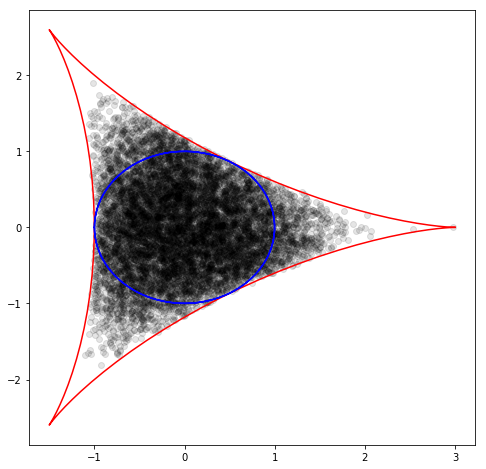

In [12]:
N = 3; eps=0.1; num_iter=100000; num_record=10; num_print=10000;
plt.figure(figsize=(8,8))
make_plot_trace(N,eps,num_iter,num_record,num_print,plt.gca())
b = np.linspace(0,2*np.pi,100)
plt.plot(2*np.cos(b)+np.cos(-2*b),2*np.sin(b)+np.sin(-2*b),color='red')
plt.plot(np.cos(-2*b-np.pi),np.sin(-2*b-np.pi),color='blue')
plt.show()

Notice something fun: the plot lies within the red curve that I've drawn over the top. We can calculate what this curve is theoretically, by thinking about what happens at the curve. All the unitary matrices can be diagonalized, so for SU(3) we will end up with eigenvalues of $e^{i\theta}, e^{i \phi}, e^{-i(\theta + \phi)}$, where the last is determined by the det=1 condition, and they all must be normalized by unitarity. In this basis its clear what the trace is, and the points on the boundary red curve must be where the gradient of the Trace (as a function of $\theta,\phi$)
$$\nabla_{\theta, \phi} \text{Trace} = (ie^{i \theta} -ie^{-i (\theta + \phi)},ie^{i \phi} -ie^{-i(\theta + \phi)})$$
becomes degenerate in the sense that the derivative in terms of $\theta$ becomes the same as the derivative in terms of $\phi$ up to a sign (since they both must push the trace along the boundary). Thinking in terms of angles, this gives us the condition:
$$(\theta + \frac{\pi}{2}) + (\theta + \phi - \frac{\pi}{2}) = (\phi + \frac{\pi}{2}) + (\theta + \phi - \frac{\pi}{2}) (+ \pi), \quad \implies \theta = \phi (+ \pi)$$
where the $(+ \pi)$ indicates that there is optionally an additional $\pi$ angle. We plotted the curve without the $\pi$ factor in red, and the curve with the $\pi$ factor in blue, and we see interestingly enough that there is an additional degeneracy along the unit circle. 

Note something else, there are barely any points near the vertices (which are given by elements in the center, in other words the diagonal matrices). That's just a consequence of the 'bulk' of the matrices (in terms of the haar measure) being far from diagonal. 

Potentially, there is some closed form for the red curves, but I have not written down any such thing. Also, note that we could do the exact same simulation/procedure for higher $N$ (I encourage you to try changing this notebook!)